# K-Anonymity of a numerical quasi-identifier using a real-world AI generated dataset from: https://www.kaggle.com/datasets/zohrehtofighizavareh/bank-personal-loan

In [157]:
import pandas as pd
original_df = pd.read_csv("Bank_Personal_Loan.csv")
bank_loan_dataset = original_df.copy()
columns_to_modify = [
    "Personal Loan", "Securities Account", "CD Account", "Online", "CreditCard"
]

for column in columns_to_modify:
    bank_loan_dataset[column] = bank_loan_dataset[column].map({0: 'No', 1: 'Yes'})

bank_loan_dataset.drop("ID", axis=1, inplace=True)
bank_loan_dataset = bank_loan_dataset[bank_loan_dataset["Experience"]>0]
bank_loan_dataset.to_csv("BankData.csv", index=False)

In [158]:
import pandas as pd

def anonymize_multidim(data, qis, k):
    assert isinstance(data, pd.DataFrame), "Data must be a Pandas dataframe"
    assert isinstance(k, int) and k > 1, "k must be an integer bigger than 1"
    assert all(qi in data.columns for qi in qis), "All QIs must be columns in the data"

    def generalize_zip_code(zip_code):
        # Convertir a cadena y reemplazar el último dígito con '0'
        zip_code_str = str(zip_code)
        if len(zip_code_str) > 1:
            return zip_code_str[:-1] + '0'
        else:
            return zip_code_str  # Manejar códigos postales de un solo dígito

    # Aplicar generalización si 'ZIP Code' está en qis
    if "ZIP Code" in qis and "ZIP Code" in data.columns:
        data["ZIP Code"] = data["ZIP Code"].apply(generalize_zip_code)

    def mondrian(data, qis, k):
        partition = []

        if len(data) <= (2 * k - 1):
            partition.append(data)
            return [data]

        # Select QI to partition
        qi = select_qi_for_partition(data, qis)

        # Sort data by QI
        data = data.sort_values(by=qi)

        # Number of total values
        si = data[qi].count()
        mid = si // 2

        # Split data
        lhs = data[:mid]
        rhs = data[mid:]

        partition.extend(mondrian(lhs, qis, k))
        partition.extend(mondrian(rhs, qis, k))

        return partition
    
    def select_qi_for_partition(data, qis):
        num_qis = [qi for qi in qis if qi in data.columns and pd.api.types.is_numeric_dtype(data[qi])]
        variances = data[num_qis].var()
        return variances.idxmax() if not variances.empty else None

    result_partitions = mondrian(data, qis, k)

    # Anonymize
    result_final = []

    for partition in result_partitions:
        anonymized_partition = partition.copy()
        for qi in qis:
            part_min = partition[qi].min()
            part_max = partition[qi].max()
            if part_min == part_max:
                anonymized_partition[qi] = str(part_min)
            else:
                anonymized_partition[qi] = f"[{part_min} - {part_max}]"
        result_final.append(anonymized_partition)

    anonymized = pd.concat(result_final)
    
    return anonymized


In [159]:
df = pd.read_csv("BankData.csv")
df.head(3)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1/60,1,0,No,Yes,No,No,No
1,45,19,34,90089,3,1/50,1,0,No,Yes,No,No,No
2,39,15,11,94720,1,1/00,1,0,No,No,No,No,No


In [160]:
k = 15
QIs = ["Age", "Income", "Family", "ZIP Code"]
df_anonymized  = anonymize_multidim(df, QIs, k)
df_anonymized.groupby(["Age", "Income", "Family", "ZIP Code"]).size().min()

19

In [161]:
df_anonymized.head(5)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
2148,[25 - 31],1,[8 - 14],[90030 - 95810],[1 - 4],1/00,1,95,No,No,No,No,Yes
3676,[25 - 31],2,[8 - 14],[90030 - 95810],[1 - 4],1/00,1,0,No,No,No,Yes,No
4407,[25 - 31],1,[8 - 14],[90030 - 95810],[1 - 4],0/90,3,0,No,No,No,No,Yes
1773,[25 - 31],3,[8 - 14],[90030 - 95810],[1 - 4],0/50,3,0,No,No,No,No,No
1028,[25 - 31],2,[8 - 14],[90030 - 95810],[1 - 4],0/10,2,0,No,No,No,Yes,Yes


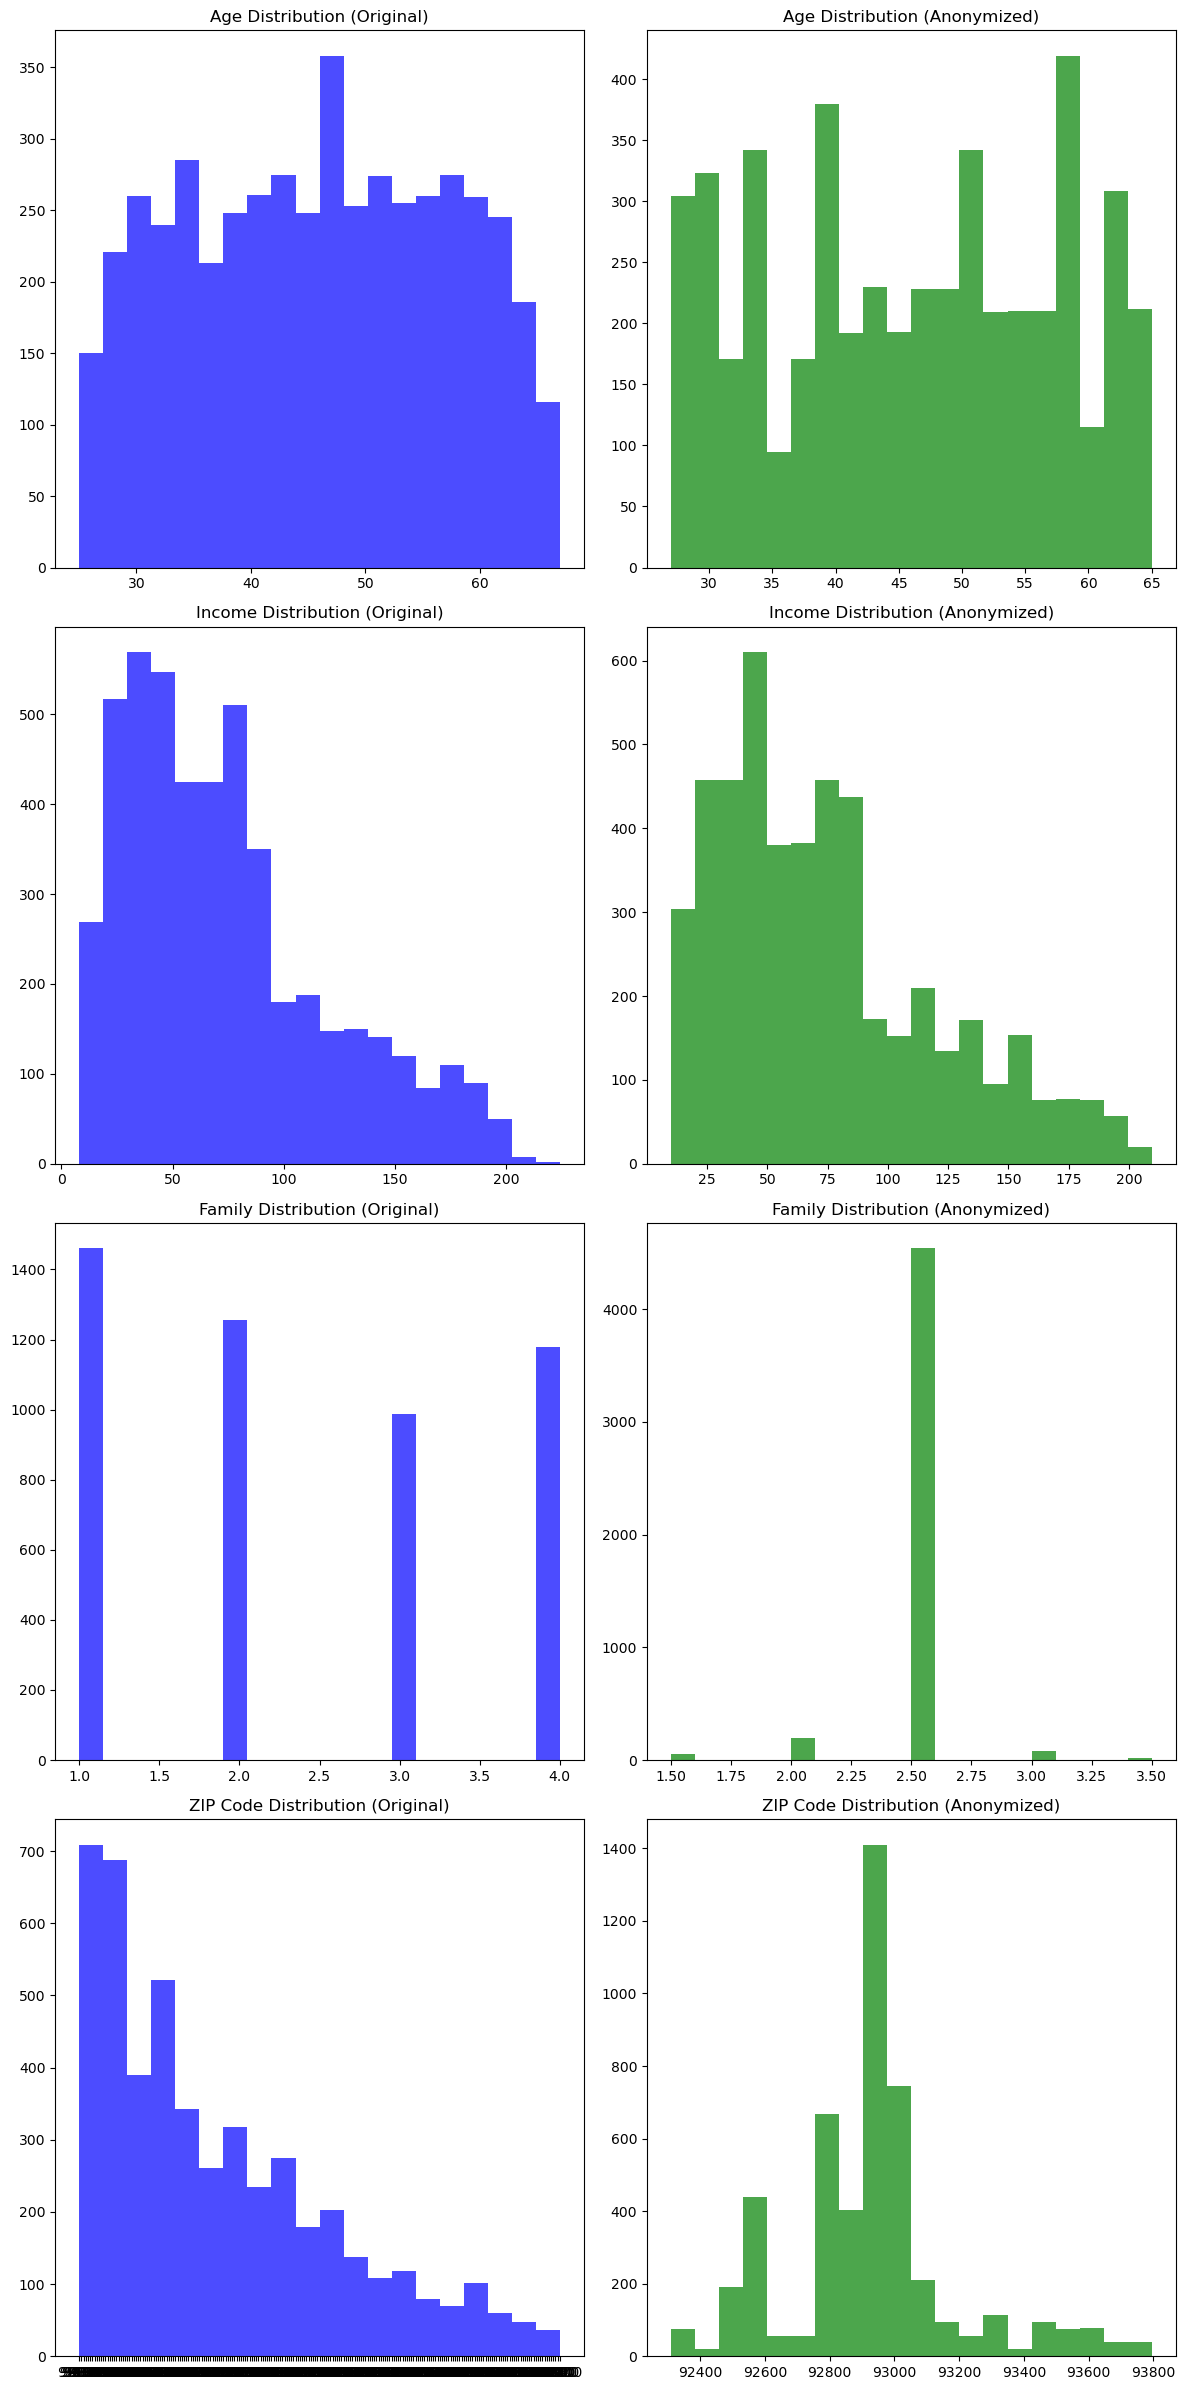

Varianza de Age (Original): 124.43598651594938
Varianza de Age (Anonimizado): 125.26378819593216

Varianza de Income (Original): 2126.3858723737135
Varianza de Income (Anonimizado): 2132.535995740006

Varianza de Family (Original): 1.3184139337200391
Varianza de Family (Anonimizado): 0.028910520196323286

Varianza de ZIP Code (Original): No aplicable (columna no numérica)
Varianza de ZIP Code (Anonimizado): 66471.81908529956



{'Age': (count    4882.000000
  mean       45.826506
  std        11.155088
  min        25.000000
  25%        36.000000
  50%        46.000000
  75%        55.000000
  max        67.000000
  Name: Age, dtype: float64,
  count    4882.000000
  mean       45.826506
  std        11.192131
  min        27.000000
  25%        36.000000
  50%        46.000000
  75%        55.500000
  max        65.000000
  Name: Age_Midpoint, dtype: float64),
 'Income': (count    4882.000000
  mean       73.870750
  std        46.112752
  min         8.000000
  25%        39.000000
  50%        64.000000
  75%        98.000000
  max       224.000000
  Name: Income, dtype: float64,
  count    4882.000000
  mean       73.923187
  std        46.179389
  min        10.000000
  25%        40.500000
  50%        64.250000
  75%        98.750000
  max       209.500000
  Name: Income_Midpoint, dtype: float64),
 'Family': (count    4882.000000
  mean        2.386112
  std         1.148222
  min         1.000000
  2

In [162]:
import numpy as np
import matplotlib.pyplot as plt

def extract_midpoint(range_str):
    # Calcular la media del rango en formato de cadena
    parts = range_str.strip('[]').split(' - ')
    if len(parts) == 2:
        return np.mean(list(map(int, parts)))
    return int(parts[0])  # Manejar valores no rangos

QIs = ["Age", "Income", "Family", "ZIP Code"]

# Crear figuras para comparar distribuciones
num_columns = len(QIs)
fig, axes = plt.subplots(num_columns, 2, figsize=(12, 6 * num_columns))

for i, column in enumerate(QIs):
    # Extraer el punto medio para cada columna anonimizada
    if column in df_anonymized.columns:
        df_anonymized[f'{column}_Midpoint'] = df_anonymized[column].apply(extract_midpoint)

        # Distribución en los datos originales
        axes[i, 0].hist(df[column], bins=20, alpha=0.7, color='blue')
        axes[i, 0].set_title(f'{column} Distribution (Original)')

        # Distribución en los datos anonimizados
        axes[i, 1].hist(df_anonymized[f'{column}_Midpoint'], bins=20, alpha=0.7, color='green')
        axes[i, 1].set_title(f'{column} Distribution (Anonymized)')

plt.tight_layout()
plt.show()

summary_metrics = {}
for column in QIs:
    if column in df.columns and f'{column}_Midpoint' in df_anonymized.columns:
        # Asegurarse de que la columna original sea numérica antes de calcular la varianza
        if pd.api.types.is_numeric_dtype(df[column]):
            variance_original = df[column].var()
            print(f"Varianza de {column} (Original): {variance_original}")
        else:
            print(f"Varianza de {column} (Original): No aplicable (columna no numérica)")

        # Calcular la varianza en los datos anonimizados
        variance_anonymized = df_anonymized[f'{column}_Midpoint'].var()
        print(f"Varianza de {column} (Anonimizado): {variance_anonymized}\n")

        summary_original = df[column].describe()
        summary_anonymized = df_anonymized[f'{column}_Midpoint'].describe()
        summary_metrics[column] = (summary_original, summary_anonymized)

summary_metrics
